# Allegro Hand iMPC
Task: 30 degrees in hand rotation

In [ ]:
import sys
sys.path.append("/root/work/planning_through_contact")

In [ ]:
import time

from pydrake.all import (
    AngleAxis,
    Quaternion,
    RigidTransform,
    OsqpSolver,
    ScsSolver,
)
from pydrake.math import RollPitchYaw
from qsim.parser import QuasistaticParser

from examples.allegro_hand.allegro_hand_setup import *
from irs_mpc2.irs_mpc import IrsMpcQuasistatic
from irs_mpc2.irs_mpc_params import SmoothingMode, IrsMpcQuasistaticParameters
from irs_mpc2.quasistatic_visualizer import QuasistaticVisualizer

In [ ]:
# %% sim setup
h = 0.01
T = 20  # num of time steps to simulate forward.
duration = T * h
max_iterations = 15

# quasistatic dynamical system
q_parser = QuasistaticParser(q_model_path_hardware)
q_vis = QuasistaticVisualizer.make_visualizer(q_parser)
q_sim, q_sim_py = q_vis.q_sim, q_vis.q_sim_py

plant = q_sim.get_plant()

dim_x = plant.num_positions()
dim_u = q_sim.num_actuated_dofs()
idx_a = plant.GetModelInstanceByName(robot_name)
idx_u = plant.GetModelInstanceByName(object_name)

# initial conditions.
q_a0 = np.array(
    [
        0.03501504,
        0.75276565,
        0.74146232,
        0.6,
        -0.1438725,
        0.74696812,
        0.61908827,
        0.5,
        -0.06922541,
        0.78533142,
        0.82942863,
        0.6,
        0.63256269,
        1.02378254,
        0.7,
        0.5,
    ]
)

q_u0 = np.array([1, 0, 0, 0, -0.08, 0.001, 0.076])
q0_dict = {idx_a: q_a0, idx_u: q_u0}

INFO:drake:PackageMap: Downloading https://github.com/RobotLocomotion/models/archive/611246c443152946e9dcc901b4f956d89a439a61.tar.gz
INFO:drake:Meshcat listening for connections at https://c39756a2-acd7-4fb0-8443-38625de2db2e.deepnoteproject.com/7000/
Installing NginX server for MeshCat on Deepnote...


In [ ]:
params = IrsMpcQuasistaticParameters()
params.h = h
params.Q_dict = {
    idx_u: np.array([10, 10, 10, 10, 1, 1, 1.0]),
    idx_a: np.ones(dim_u) * 5e-2,
}

params.Qd_dict = {}
for model in q_sim.get_actuated_models():
    params.Qd_dict[model] = params.Q_dict[model]
for model in q_sim.get_unactuated_models():
    params.Qd_dict[model] = params.Q_dict[model] * 100

params.R_dict = {idx_a: 20 * np.ones(dim_u)}

u_size = 2.5
params.u_bounds_abs = np.array(
    [-np.ones(dim_u) * u_size * h, np.ones(dim_u) * u_size * h]
)

params.smoothing_mode = SmoothingMode.k1AnalyticIcecream
# sampling-based bundling
params.calc_std_u = lambda u_initial, i: u_initial / (i**0.8)
params.std_u_initial = np.ones(dim_u) * 0.2
params.num_samples = 100
# analytic bundling
params.log_barrier_weight_initial = 200
log_barrier_weight_final = 6000
base = (
    np.log(log_barrier_weight_final / params.log_barrier_weight_initial)
    / max_iterations
)
base = np.exp(base)
params.calc_log_barrier_weight = lambda kappa0, i: kappa0 * (base**i)

params.use_A = False
params.rollout_forward_dynamics_mode = ForwardDynamicsMode.kSocpMp

prob_mpc = IrsMpcQuasistatic(q_sim=q_sim, parser=q_parser, params=params)

In [ ]:
prob_mpc.sim_params.use_free_solvers = True
prob_mpc.sim_params_rollout.use_free_solvers = True
prob_mpc.solver = OsqpSolver()

In [ ]:
Q_WB_d = RollPitchYaw(0, 0, np.pi / 6).ToQuaternion()
p_WB_d = q_u0[4:] + np.array([0, 0, 0], dtype=float)
q_d_dict = {idx_u: np.hstack([Q_WB_d.wxyz(), p_WB_d]), idx_a: q_a0}
x0 = q_sim.get_q_vec_from_dict(q0_dict)
u0 = q_sim.get_q_a_cmd_vec_from_dict(q0_dict)
xd = q_sim.get_q_vec_from_dict(q_d_dict)
x_trj_d = np.tile(xd, (T + 1, 1))
u_trj_0 = np.tile(u0, (T, 1))
prob_mpc.initialize_problem(x0=x0, x_trj_d=x_trj_d, u_trj_0=u_trj_0)

In [ ]:
# %% visualize goal.
q_vis.draw_configuration(q_sim.get_q_vec_from_dict(q0_dict))
q_vis.draw_object_triad(
    length=0.1, radius=0.001, opacity=1, path="sphere/sphere"
)

q_vis.draw_goal_triad(
    length=0.1,
    radius=0.005,
    opacity=0.5,
    X_WG=RigidTransform(Q_WB_d, p_WB_d),
)

'goal'

In [ ]:
t0 = time.time()
prob_mpc.iterate(max_iterations=max_iterations, cost_Qu_f_threshold=1)
t1 = time.time()

Iter 00, cost: 81.3809, time: 0.00.
Iter 01, cost: 23.5787, time: 1.21.
Iter 02, cost: 29.4785, time: 2.44.
Iter 03, cost: 30.0214, time: 3.64.
Iter 04, cost: 38.2863, time: 4.77.
Iter 05, cost: 51.7097, time: 5.91.
Iter 06, cost: 41.2414, time: 7.06.
Iter 07, cost: 35.6109, time: 8.24.
Iter 08, cost: 25.0298, time: 9.37.
Iter 09, cost: 30.2941, time: 10.59.
Iter 10, cost: 24.0604, time: 11.73.
Iter 11, cost: 25.0012, time: 12.90.
Iter 12, cost: 19.1522, time: 14.08.
Iter 13, cost: 16.9558, time: 15.29.
Iter 14, cost: 13.3394, time: 16.59.
Iter 15, cost: 9.2927, time: 17.86.


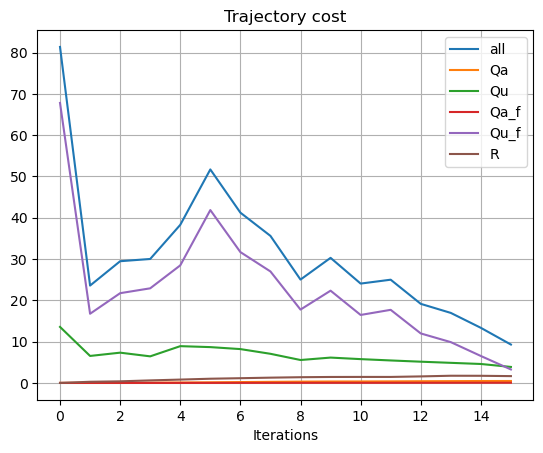

In [ ]:
prob_mpc.plot_costs()
q_vis.publish_trajectory(prob_mpc.x_trj_best, h * 10)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=e6da5e88-a306-408e-baee-7ac057f80520' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>